In [1]:
import sys as _sys
import os

current_path = os.path.abspath(os.getcwd())

split = current_path.split("inverse_geometric_locomotion")
if len(split)<2:
    print("Please rename the repository 'inverse_geometric_locomotion'")
    raise ValueError
path_to_python_scripts = os.path.join(split[0], "inverse_geometric_locomotion/python/")
path_to_cubic_splines = os.path.join(split[0], "inverse_geometric_locomotion/ext/torchcubicspline/")
path_to_output = os.path.join(split[0], "inverse_geometric_locomotion/output/")
path_to_output_obstacle = os.path.join(path_to_output, "obstacles/")

if not os.path.exists(path_to_output_obstacle):
    os.makedirs(path_to_output_obstacle)

_sys.path.insert(0, path_to_python_scripts)
_sys.path.insert(0, path_to_cubic_splines)

In [2]:
import numpy as np
import torch
from obstacle_implicits import BoxImplicit, SphereImplicit, ComplementaryImplicit, UnionImplicit, IntersectionImplicit, generate_siggraph_implicit, MoonImplicit
from vis_utils import plot_sdf_2d


# SDF of a box

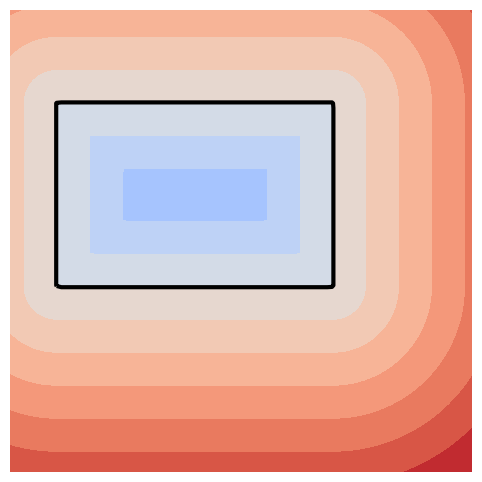

In [3]:
n_plot = 100
x_plot = torch.linspace(0.0, 1.0, n_plot)
xyz_plot = torch.stack([
    torch.tile(x_plot, dims=(n_plot,)),
    torch.repeat_interleave(x_plot, repeats=n_plot, dim=0),
    torch.zeros(size=(n_plot*n_plot,))
], dim=1)

box_center = torch.tensor([0.4, 0.6, 0.0])
box_dims = torch.tensor([0.3, 0.2, 0.5])
box_params = torch.cat([box_center, box_dims], dim=0)

box_implicit = BoxImplicit(box_params)

sdfs = box_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=None)


# Get the Union

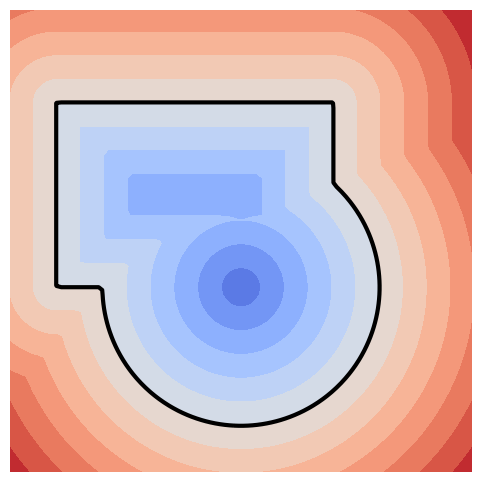

In [4]:
sphere_params = torch.tensor([0.5, 0.4, 0.0, 0.3])
sphere_implicit = SphereImplicit(sphere_params)
union_implicit = UnionImplicit([box_implicit, sphere_implicit])

sdfs = union_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=None)

# Get the Complementary

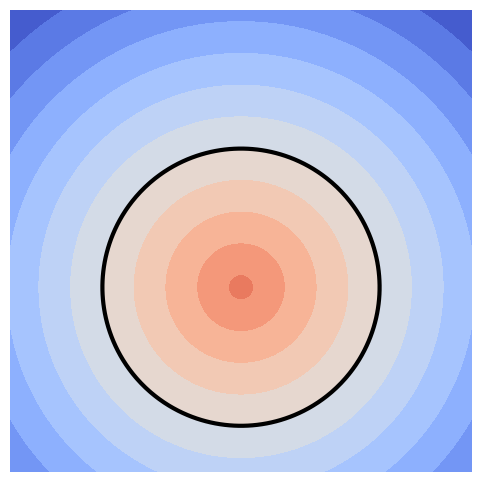

In [5]:
sphere_complementary_implicit = ComplementaryImplicit(sphere_implicit)

sdfs = sphere_complementary_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=None)

# Intersect Complementary and original Box

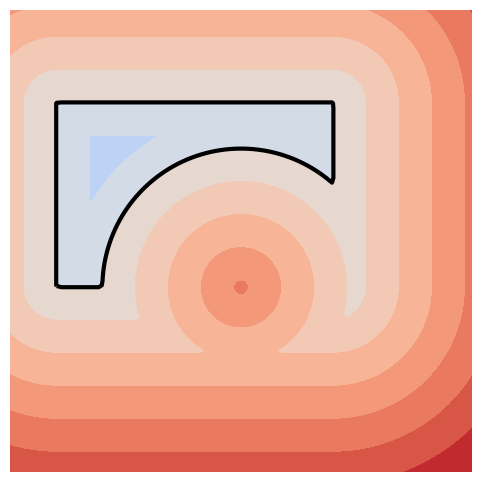

In [6]:
intersection_implicit = IntersectionImplicit([box_implicit, sphere_complementary_implicit])

sdfs = intersection_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=None)

# Siggraph logo approximation

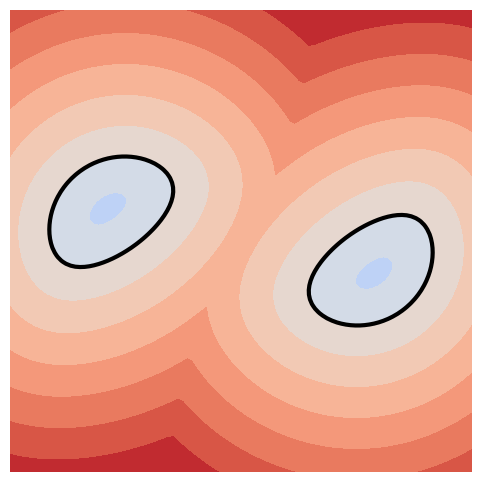

In [9]:
n_plot = 100
x_plot = torch.linspace(-3.0, 3.0, n_plot)
xyz_plot = torch.stack([
    torch.tile(x_plot, dims=(n_plot,)),
    torch.repeat_interleave(x_plot, repeats=n_plot, dim=0),
    torch.zeros(size=(n_plot*n_plot,))
], dim=1)

angle_rot = np.pi / 5.0
translate_implicit = torch.tensor([-1.5, 0.1, 0.0])
scale_implicit = torch.tensor([1.0, 1.0, 1.0])
intersection_sharpness = torch.tensor(5.0)
siggraph_implicit = generate_siggraph_implicit(angle_rotation=angle_rot, translation=translate_implicit, scale=scale_implicit, intersection_sharpness=intersection_sharpness)

sdfs = siggraph_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=None)

In [8]:
assert 0

AssertionError: 

# Exact- vs Pseudo-SDFs

## Exact SDF of the moon

In [ ]:
n_plot = 1000
x_plot = torch.linspace(-1.0, 1.0, n_plot)
xyz_plot = torch.stack([
    torch.tile(x_plot, dims=(n_plot,)),
    torch.repeat_interleave(x_plot, repeats=n_plot, dim=0),
    torch.zeros(size=(n_plot*n_plot,))
], dim=1)

moon_params = torch.tensor([0.7, 0.5, 0.3])
moon_implicit = ComplementaryImplicit(MoonImplicit(moon_params))
moon_implicit = MoonImplicit(moon_params)

sdfs = moon_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=os.path.join(path_to_output_obstacle, "moon_sdf.png"))

## Pseudo-SDF as an intersection

In [ ]:
sphere_inside_params = torch.tensor([moon_params[2], 0.0, 0.0, moon_params[1]])
sphere_outside_params = torch.tensor([0.0, 0.0, 0.0, moon_params[0]])
sphere_inside_implicit = SphereImplicit(sphere_inside_params)
sphere_inside_comp_implicit = ComplementaryImplicit(sphere_inside_implicit)
sphere_outside_implicit = SphereImplicit(sphere_outside_params)
moon_intersection_implicit = ComplementaryImplicit(IntersectionImplicit([sphere_inside_comp_implicit, sphere_outside_implicit]))
moon_intersection_implicit = IntersectionImplicit([sphere_inside_comp_implicit, sphere_outside_implicit])

sdfs = moon_intersection_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=os.path.join(path_to_output_obstacle, "moon_pseudo_sdf.png"))

In [ ]:
sphere_inside_params = torch.tensor([moon_params[2], 0.0, 0.0, moon_params[1]])
sphere_outside_params = torch.tensor([0.0, 0.0, 0.0, moon_params[0]])
sphere_inside_implicit = SphereImplicit(sphere_inside_params)
sphere_inside_comp_implicit = ComplementaryImplicit(sphere_inside_implicit)
sphere_outside_implicit = SphereImplicit(sphere_outside_params)
moon_intersection_implicit = ComplementaryImplicit(IntersectionImplicit([sphere_inside_comp_implicit, sphere_outside_implicit]))

sdfs = moon_intersection_implicit.evaluate_implicit_function(xyz_plot).reshape(n_plot, n_plot)

plot_sdf_2d(x_plot, x_plot, sdfs, n_levels=15, show_text=False, filename=None)